In [41]:
WORKDIR = "path/to/WORKDIR/"  # specify WORKDIR here

In [42]:
import matplotlib.pyplot as plt
from paper_utils import get_figsize, configure_matplotlib
from calculate_MMD import get_files_from_directory,extract_model_details_from_filename,get_filter_info
import pickle 
import os 
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import os

In [43]:
configure_matplotlib(
    rc={
        "xtick.labelbottom": False,
        "xtick.bottom": True,
        "xtick.labeltop": True,
        "ytick.left": True,
        "figure.constrained_layout.use": False,
        "savefig.pad_inches": 0.01,
    }
)

In [44]:
experiments = [ "gragnaniello2021/progan", "gragnaniello2021/stylegan2",
                "wang2020/blur_jpg_prob0.1", "wang2020/blur_jpg_prob0.5",
                "wang2020/finetuning_All", "wang2020/finetuning_GAN", "wang2020/finetuning_DM",
                "wang2020/scratch_All", "wang2020/scratch_GAN", "wang2020/scratch_DM"]
input_path = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/t-sne"
output_path = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/"
    

In [50]:

experiemnts = {}
path_names = []
base_input_folder = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/t-sne/"
mmds = get_files_from_directory(base_input_folder)
mmd = mmds["fake_vs_real"]
print(mmd)
for file in  mmd:
    
    with open(file, "rb") as input_file:
        mmds_GANs = pickle.load(input_file)
    
    experiemnt_name = file.split("/")[-1]
    experiemnts[experiemnt_name] = mmds_GANs
print(experiemnts.keys())
sorted_dict = {}
for key, value in experiemnts.items():
    experiemnt_key = key.split("_")[0]
    model_name = key.split("_")[1]
    
        
        #sorted_dict[experiemnt_key][model_name] = value
    for new_key, new_value in value.items():
        if new_key not in ["real","00","06"]:
            continue
        sorted_dict[f"{experiemnt_key}{new_key}"] = {}
        sorted_dict[f"{experiemnt_key}{new_key}"] = new_value
print(sorted_dict.keys())

['/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/t-sne/fake_vs_real/DinoV2_big.pkl', '/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/t-sne/fake_vs_real/OpenClip_big.pkl']
dict_keys(['DinoV2_big.pkl', 'OpenClip_big.pkl'])
dict_keys(['DinoV206', 'DinoV200', 'DinoV2real', 'OpenClip06', 'OpenClip00', 'OpenClipreal'])


(8000, 2)
(8000, 2)
(8000, 2)
(8000, 2)
(8000, 2)
(8000, 2)


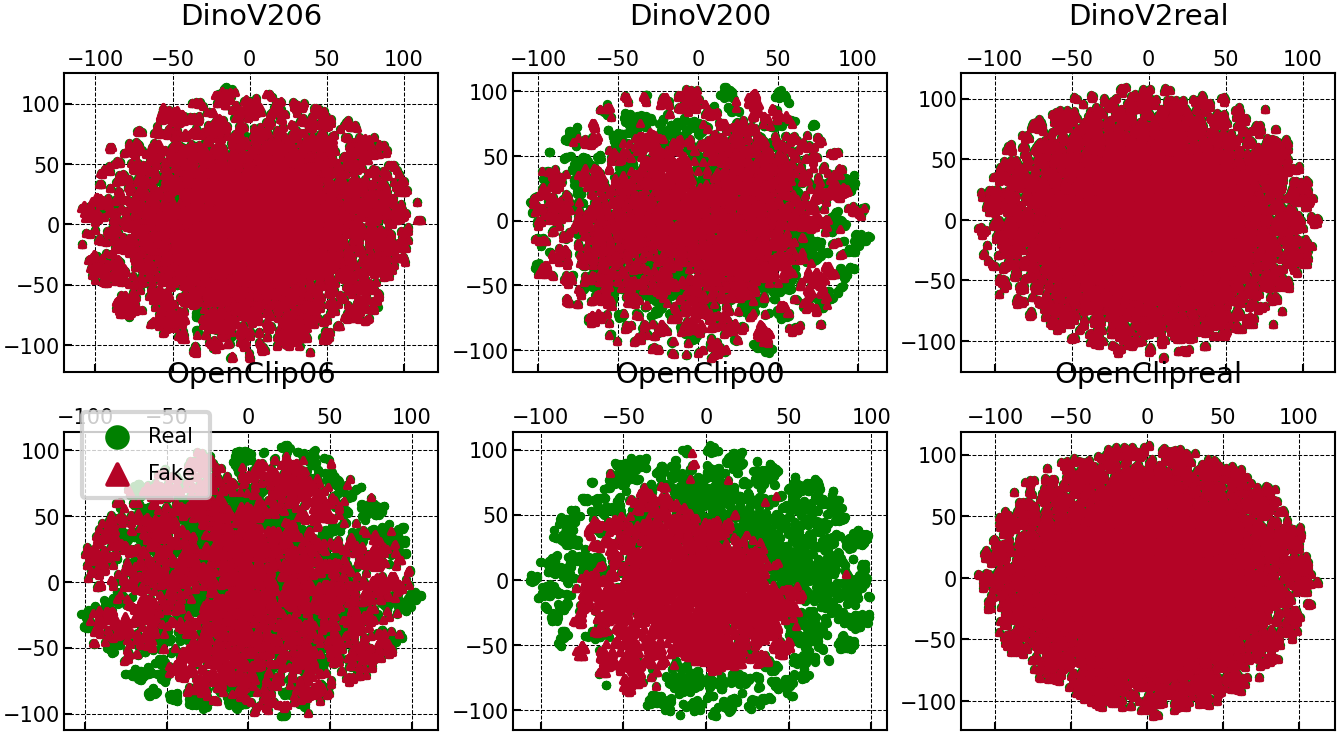

In [51]:
# Visualize the t-SNE embeddings

cm = plt.get_cmap('coolwarm')

size = 1.5 # size of each marker
n_plot = 4000  # number of samples to visualize per class
alpha = 1   # opacity

fig, axes = plt.subplot_mosaic(
   [[0,1,2],[3,4,5]], 
    # set the height ratios between the rows
    height_ratios=[1, 1],
    # set the width ratios between the columns
    width_ratios=[1, 1, 1],
    constrained_layout=False,
    figsize=get_figsize(ratio=0.52),
    sharey=False,
    sharex=False
)

for i, experiment in enumerate(sorted_dict.items()):
    name, data = experiment
    ax = axes[i]
    
    # Load embedded features
    # First entry is real value
    print(data.shape)
    
    ax.scatter(data[:n_plot, 0], data[:n_plot, 1], alpha=alpha, s=size, label="Real", marker="o", c="g", zorder=4)  # Circle for real data
    ax.scatter(data[n_plot:2*n_plot,0], data[n_plot:2*n_plot,1], alpha = alpha, s=size, label="Fake", marker="^", color=cm(1.0), zorder=4)  # Square for fake data
    ax.set_title(name)

handles, labels = fig.gca().get_legend_handles_labels()

by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), markerscale=4, ncol=1, borderpad=0.7,
           bbox_to_anchor=(0.22, 0.495), labelspacing=0.8, columnspacing=0.8)
plt.show()

In [47]:



import torch
def euclidean_distance(a, b):
    return torch.linalg.norm(a - b)

def intra_cluster_distance_accuracy(cluster, real_image_feature):
    """
    Computes the Min and Max Intra-Cluster Distance Accuracy for a single cluster.
    
    Parameters:
    - cluster: a list of fake image features.
    - real_image_feature: the feature representation of the real image.
    
    Returns:
    - min_accuracy: the Min Intra-Cluster Distance Accuracy.
    - max_accuracy: the Max Intra-Cluster Distance Accuracy.
    """
    distances = [euclidean_distance(real_image_feature, fake_image) for fake_image in cluster]
    print(distances)
    min_accuracy = 1 if torch.argmin(distances) == 0 else 0
    max_accuracy = 1 if torch.argmax(distances) == 0 else 0
    
    return min_accuracy, max_accuracy

def compute_accuracy_for_clusters(clusters, real_image_features):
    """
    Computes the Min and Max Intra-Cluster Distance Accuracy metrics for all clusters.
    
    Parameters:
    - clusters: a list of clusters, where each cluster is a list of fake image features.
    - real_image_features: a list of feature representations for the real images, in the same order as clusters.
    
    Returns:
    - average_min_accuracy: the average Min Intra-Cluster Distance Accuracy over all clusters.
    - average_max_accuracy: the average Max Intra-Cluster Distance Accuracy over all clusters.
    """
    total_min_accuracy = 0
    total_max_accuracy = 0
    
    for i, cluster in enumerate(clusters):
        min_accuracy, max_accuracy = intra_cluster_distance_accuracy(cluster, real_image_features[i])
        total_min_accuracy += min_accuracy
        total_max_accuracy += max_accuracy
    
    average_min_accuracy = total_min_accuracy / len(clusters)
    average_max_accuracy = total_max_accuracy / len(clusters)
    
    return average_min_accuracy, average_max_accuracy



import torchdrift
import torch
input_path = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/embeddings"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drift_detector = torchdrift.detectors.KernelMMDDriftDetector(return_p_value=True)
all_files = get_files_from_directory(input_path)
real_image = []


# for i in tqdm.tqdm(range(1000)):
#     xy = xy[torch.randperm(len(xy))]
#     mmds.append(mmd(xy[:N_X], xy[N_X:], sigma).item())
# mmds = torch.tensor(mmds)

for key,value in tqdm(all_files.items()):

    path_to_no_filter = [file for file in value if "real" == get_filter_info(file)]
    for real_image_no_filter in path_to_no_filter:
        X_real_embedding = torch.load(real_image_no_filter).to(device)
        model_name, model_size = extract_model_details_from_filename(real_image_no_filter)
        real_filter_info = get_filter_info(real_image_no_filter)
        #Get the fake images for the same model 
        filtered_embeddings = [file for file in value if model_name in file and "00" in get_filter_info(file)]
        mmds_DM = {}
        current_max_min = []
        new_filter_size = ""
        mean_distance = 0
        for filtered_embedding in filtered_embeddings:
            filter_size = get_filter_info(filtered_embedding)
            X_fake_embedding = torch.load(filtered_embedding).to(device)
            distance_matrix = torch.linalg.norm(X_real_embedding-X_fake_embedding, dim=1)
            print(distance_matrix)
            mean_distance = torch.std(distance_matrix)
            
        
        print(f"Model: {model_name},key {key} Filter Size Real: {real_filter_info}, Filter Size Fake: {new_filter_size}, min: {mean_distance}")
    # X_real_image_not_filter = torch.load(real_image_no_filter).to(device)
    # filter_size_real = get_filter_info(real_image_no_filter)
    # model_name, model_size = extract_model_details_from_filename(real_image_no_filter)
    # fake_images_with_filter = [file for file in all_files["1.0"] if model_name in file and model_size in file]
    # tsne_embedding = {}
    # for fake_image_with_filter in fake_images_with_filter:
    #     filter_size = get_filter_info(fake_image_with_filter)
    #     X_fake_image_filter = torch.load(fake_image_with_filter).to(device)
        
        #min_acc, max_acc = intra_cluster_distance_accuracy(X_fake_image_filter, X_real_image_not_filter)
        #p_val = drift_detector.compute_p_value(X_fake_image_filter)
        
        

drift_detector.fit()

100%|██████████| 3/3 [00:00<00:00, 80145.94it/s]


TypeError: Detector.fit() missing 1 required positional argument: 'x'